In [1]:
import pandas as pd
import networkx as nx # if 'module not found' -> !pip install networkx
import matplotlib.pyplot as plt
import numpy as np
from pyvis.network import Network
# if 'module not found' -> !pip install pyvis

datadir = './'

In [2]:
# read the node and the edge matrix
dfnode = pd.read_excel(datadir + 'network-map.xlsx', sheet_name='node')

# make sure the columns are string not number and drop duplicates
dfnode['label'] = dfnode['label'].astype(str).str.strip()
dfnode['project type'] = dfnode['project type'].fillna('keyword')
dfnode = dfnode.drop_duplicates().reset_index(drop=True)

# select only 'project' nodes (comment the line if you want all nodes)
#dfnode = dfnode[dfnode['node type'] == 'project'].reset_index(drop=True)

dfedge = pd.read_excel(datadir + 'network-map.xlsx', sheet_name='edge')

# make sure columns are string not number
dfedge['node1'] = dfedge['node1'].astype(str).str.strip()
dfedge['node2'] = dfedge['node2'].astype(str).str.strip()

# sort the node1, node2 columns-wise so that we can remove duplicates such as
# project1 -> project2 and project2 -> project1
dfedge.loc[:, ['node1', 'node2']] = np.sort(dfedge[['node1', 'node2']].values, axis=1)
dfedge = dfedge.drop_duplicates().reset_index(drop=True)

# only select the edge for which both end nodes are in dfnode
dfedge = dfedge[dfedge['node1'].isin(dfnode['label'].tolist()) & dfedge['node2'].isin(dfnode['label'].tolist())].reset_index(drop=True)

print('{:d} nodes and {:d} edges'.format(dfnode.shape[0], dfedge.shape[0]))

145 nodes and 368 edges


In [3]:
dfnode.head()  # .head() displays the first 5 rows of the dataframe

,label,project type,node type,size,Unnamed: 4
0,LIFE AgroClimaWater,LIFE climate change adaptation,project,2,NaN
1,agriculture,keyword,keyword,1,NaN
2,water resources management,keyword,keyword,1,NaN
3,water shortage,keyword,keyword,1,NaN
4,climate resilience,keyword,keyword,1,NaN


In [4]:
dfedge.head()

,node1,node2,weight,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,LIFE ADAPT2CLIMA,LIFE AgroClimaWater,1,NaN,NaN,NaN,NaN
1,LIFE AGRI ADAPT,LIFE AgroClimaWater,1,NaN,NaN,NaN,NaN
2,LIFE AgroClimaWater,agriculture,1,NaN,NaN,NaN,NaN
3,LIFE AgroClimaWater,water resources management,1,NaN,NaN,NaN,NaN
4,LIFE AgroClimaWater,water shortage,1,NaN,NaN,NaN,NaN


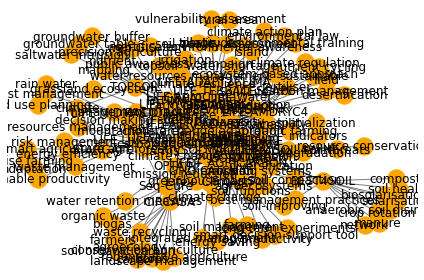

In [5]:
# build the graph
G = nx.Graph()

# adding nodes
for i in range(dfnode.shape[0]):
    row = dfnode.loc[i, :]
    G.add_node(str(row['label']), title=str(row['project type']),
               size=float(row['size'])*5, group=str(row['project type']))
    # the title, size and group are used by pyvis but not by networkx
    # networkx requires nx.draw_networkx with additional arguments
    # similar remarks for the edges. This is the best of my knowledge so far

# adding edges (links)
for i in range(dfedge.shape[0]):
    row = dfedge.loc[i, :]
    G.add_edge(row['node1'], row['node2'])#, weight=row['weight']*10)

# draw the network graph
pos = nx.spring_layout(G)  # positions for all nodes
fig, ax = plt.subplots()
nx.draw_networkx_edges(G, pos, ax=ax, width=dfedge['weight'], alpha=0.5)
nx.draw_networkx_nodes(G, pos, alpha=1, ax=ax, node_color='orange')#, node_size=dfnode['size'].values*1)
nx.draw_networkx_labels(G, pos, font_family="sans-serif", ax=ax)
plt.axis("off")
fig.tight_layout()
#nx.draw(G)

In [6]:
# interactive graph
nt = Network('100%', '100%', notebook=True)
nt.from_nx(G)
nt.show_buttons(filter_=['physics'])  # uncomment this line to show the options
nt.show('nx.html') # can also open the .html